In [5]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

In [6]:
# Реализация RNN
class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(1, hidden_size) * 0.01
        self.b_y = np.zeros((1, 1))

    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            # ReLU
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]

    def backward(self, inputs, target, lr = 0.001):
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = 0, 0
        dh_next = np.zeros_like(self.hs[0])

        dy = (self.outputs[-1] - target.reshape(-1, 1))
        dW_hy += dy @ self.hs[-1].T
        db_y += dy

        dh = self.W_hy.T @ dy + dh_next
        for t in reversed(range(len(inputs))):
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]

            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh

            dh = self.W_hh.T @ dtanh

        clip_value = 5.0
        for grad in [dW_xh, dW_hh, dW_hy]:
            np.clip(grad, -clip_value, clip_value, out = grad)

        self.W_xh -= lr * dW_xh
        self.W_hh -= lr * dW_hh
        self.b_h -= lr * db_h
        self.W_hy -= lr * dW_hy
        self.b_y -= lr * db_y

In [7]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data["Close"][ticker].values

# Нормализация данных
scaler = StandardScaler()

# Создание последовательностей
def create_sequences(data, seq_length, forecast_horizon=30):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))
# print(len(X_test),len(y_test))

[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.956470
Epoch 10, Loss: 0.007813
Epoch 20, Loss: 0.007081
Epoch 30, Loss: 0.006713
Epoch 40, Loss: 0.006492
Epoch 50, Loss: 0.006345
Epoch 60, Loss: 0.006241
Epoch 70, Loss: 0.006164
Epoch 80, Loss: 0.006105
Epoch 90, Loss: 0.006058


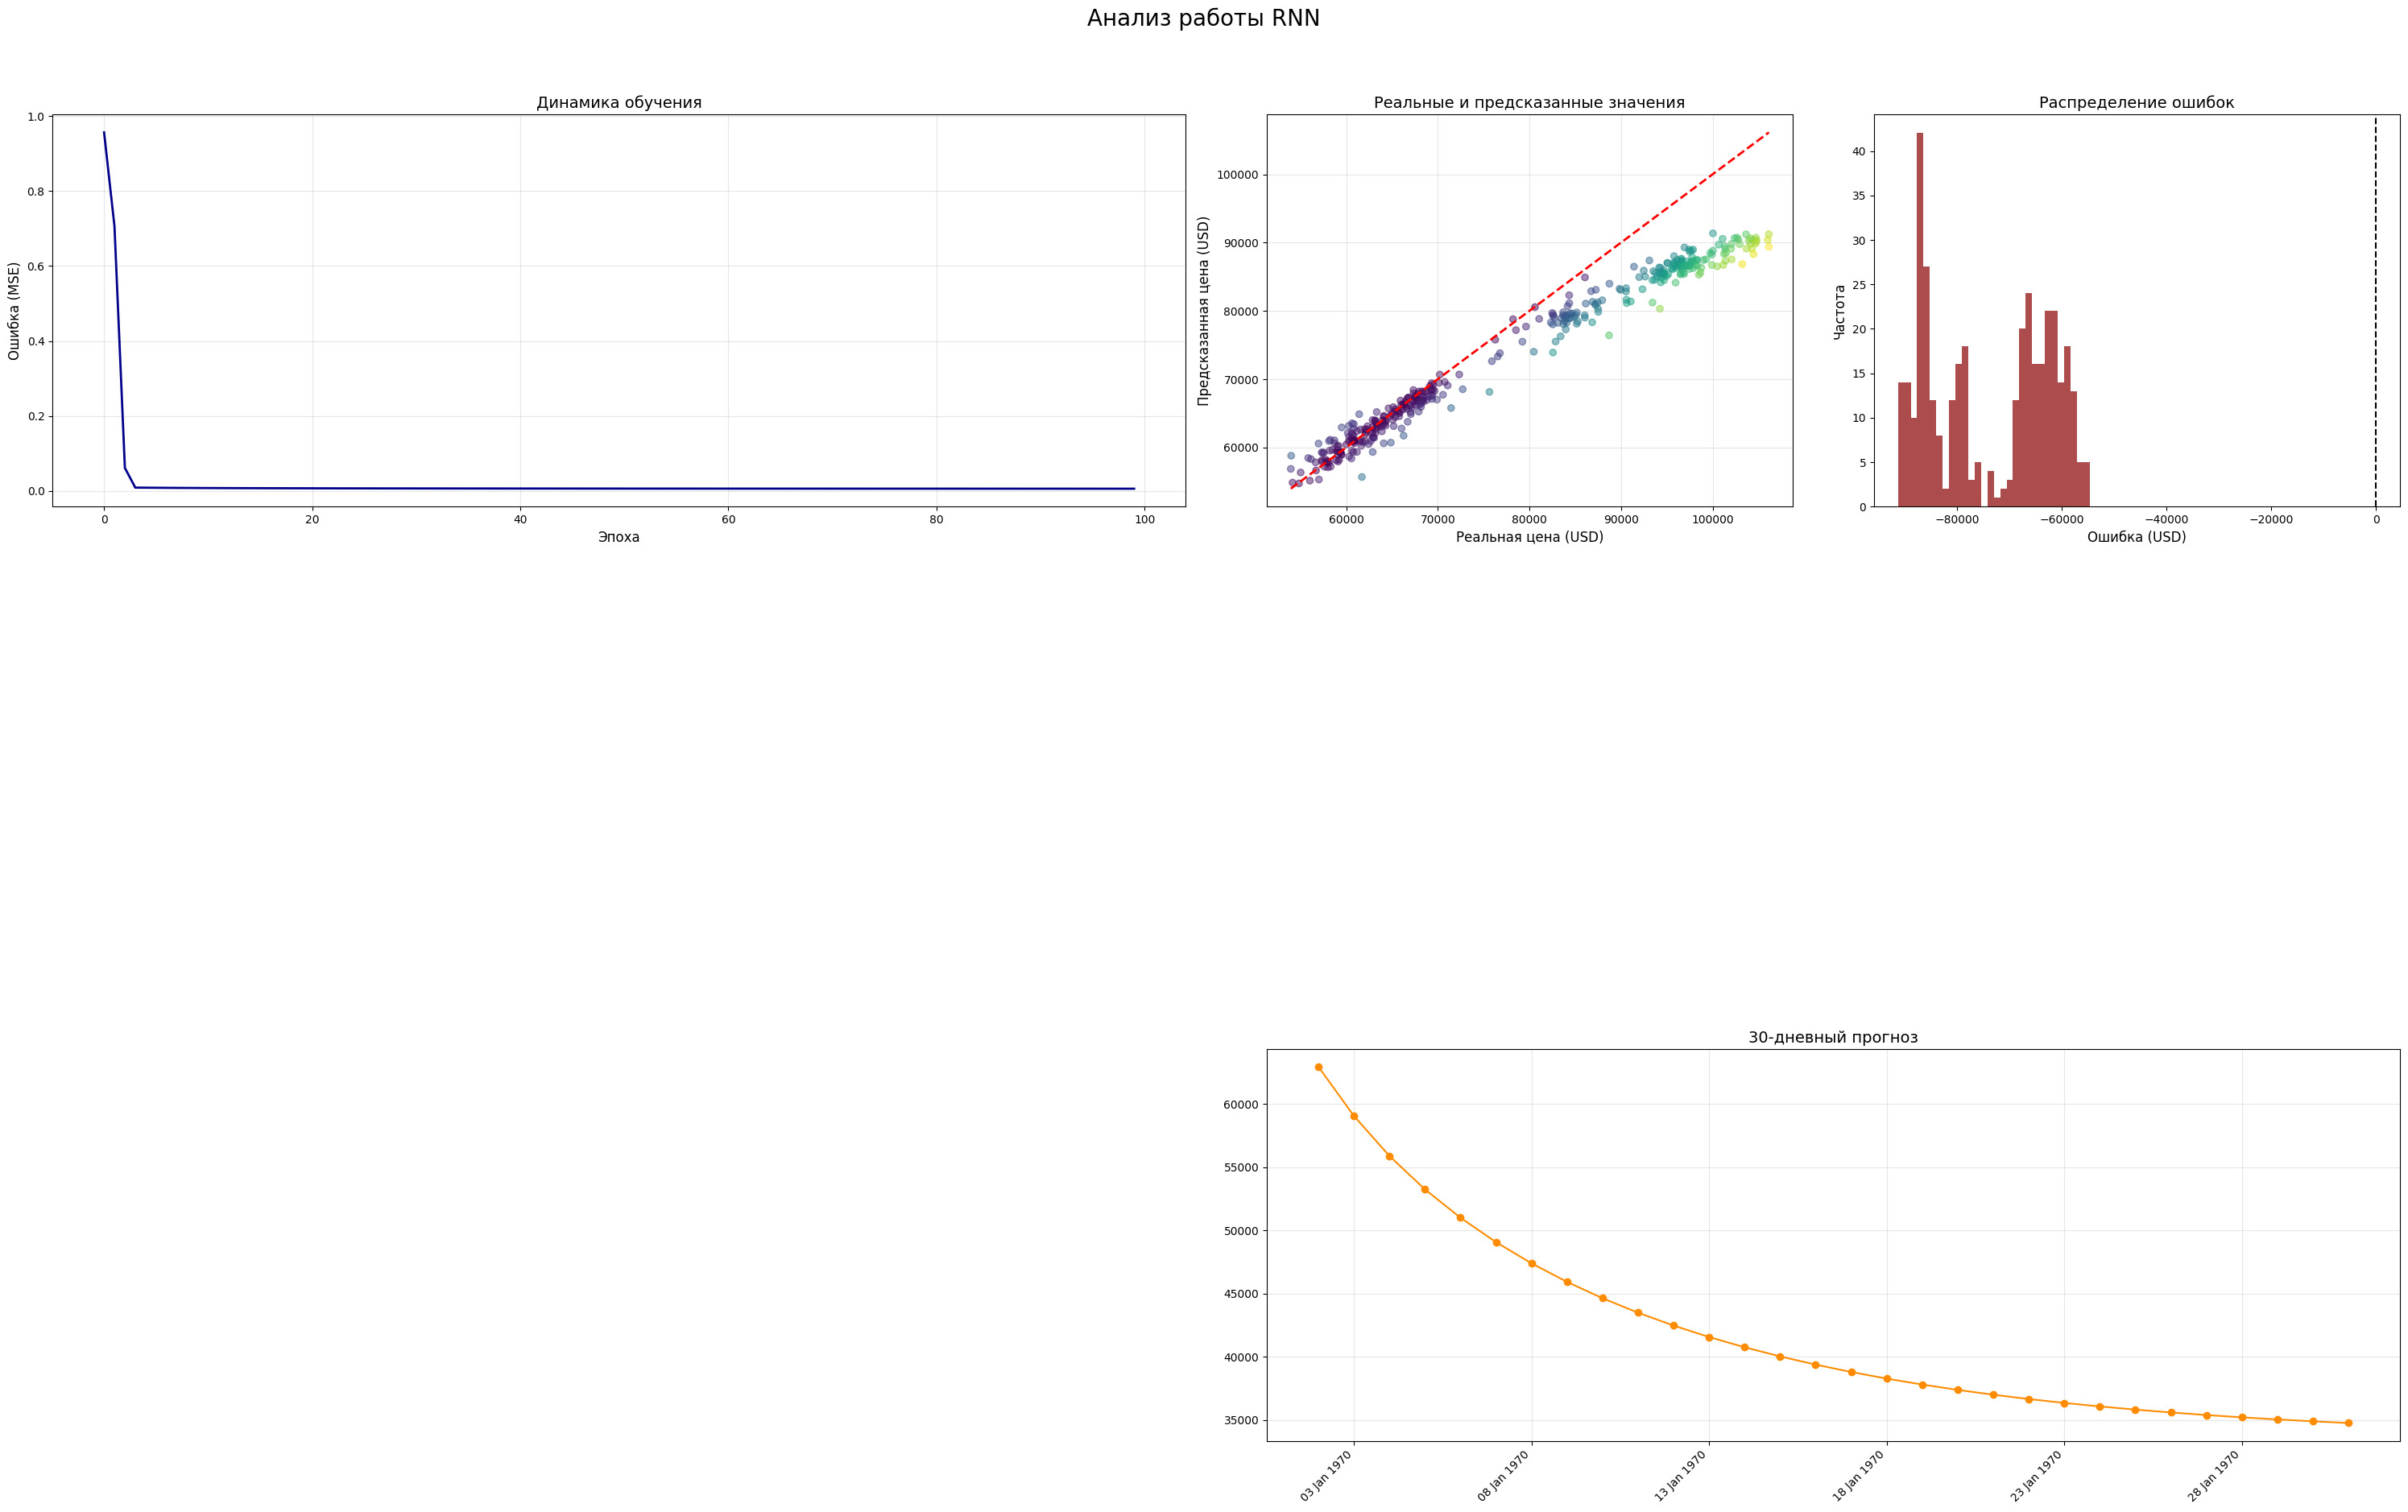

In [8]:
# Параметры модели
input_size = 1
hidden_size = 32
lr = 0.001
epochs = 100

rnn = SimpleRNN(input_size, hidden_size)

# Обучение модели
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(-1, 1)
        target = y_train[i]
        output = rnn.forward(inputs)
        loss = (output - target.reshape(-1, 1)) ** 2
        epoch_loss += loss.item()
        rnn.backward(inputs, target, lr)

    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Функция прогнозирования (измененная)
def forecast(model, last_sequence, days=30, verbose=False):
    predictions = []
    confidence = []
    current_seq = last_sequence.copy()

    pred_history = []
    mean_values = []
    std_values = []

    for day in range(days):
        input_tensor = torch.FloatTensor(current_seq).unsqueeze(0)
        with torch.no_grad():
            next_pred = model.forward(current_seq)

        pred_value = next_pred.item()
        predictions.append(pred_value)
        pred_history.append(pred_value)

        # Анализ стабильности предсказаний
        if len(pred_history) > 5:
            last_5_preds = pred_history[-5:]
            mean_val = np.mean(last_5_preds)
            std_val = np.std(last_5_preds)
            mean_values.append(mean_val)
            std_values.append(std_val)

        # Обновление последовательности
        decay_factor = 0.95  # Коэффициент затухания
        new_seq = np.append(current_seq[1:], pred_value) * np.array([decay_factor**(i+1) for i in range(len(current_seq)-1)] + [1.0])
        current_seq = new_seq.reshape(-1, 1)
    return predictions

# Генерация предсказаний на тестовых данных
test_predictions = []
for i in range(len(X_test)):
    inputs = X_test[i].reshape(-1, 1)
    output = rnn.forward(inputs)
    test_predictions.append(output.item())

# Преобразование предсказаний обратно в исходный масштаб цен
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Прогноз на N дней
last_sequence = y_train[-seq_length:].reshape(-1, 1)
scaled_forecast = forecast(rnn, last_sequence)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы RNN", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(loss_history, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_inv, test_predictions_inv, alpha = 0.5, c = np.abs(y_test_inv - test_predictions_inv), cmap = "viridis")

min_val = min(y_test_inv.min(), test_predictions_inv.min())
max_val = max(y_test_inv.max(), test_predictions_inv.max())
ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth = 2)

ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test - test_predictions_inv
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)


plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

1)Использовали StandardScaler, вместо MinMax

2)В качестве данных стали использовать не только столбец Close

3)Данные были сначала отнормированы, затем разделены, нужно наоборот

4)Изменили функцию forecast

5)last_sequence = y_train[-seq_length:].reshape(-1, 1)